# Hodographs

## Setup

In [1]:
# Import statements
import xarray as xr
import matplotlib.pyplot as plt
from typing import List
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import Hodograph
from metpy.units import units
import numpy as np
import numpy.typing as npt
from matplotlib.patches import Rectangle
from scipy.interpolate import interp1d

plt.style.use("dark_background")


In [2]:
# Define useful functions
def get_wofs_all(init: int) -> xr.Dataset:
    """Read in WoFS output based on initialization time."""
    file_pattern = f"/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc"
    loaded = xr.open_mfdataset(
        file_pattern, combine="nested", concat_dim="time", chunks="auto"
    )

    if init < 6:
        start_time = f"2021-09-02 {init:02d}:00:00"
        end_time = f"2021-09-02 {init + 6:02d}:00:00"
    else:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-02 {init - 24 + 6:02d}:00:00"

    loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
    return loaded


def calculate_layer_mean_wind(u, v, z, z_min=0, z_max=6000):
    mask = (z.values < z_max) & (z_min < z.values)
    u_masked = u[mask]
    v_masked = v[mask]
    z_masked = z[mask]

    if int(mask.sum()) > 1:
        # Calculate the thickness of each layer (difference in adjacent heights)
        layer_thickness = np.diff(z_masked)
        layer_thickness = np.append(
            layer_thickness, layer_thickness[-1]
        )  # Assume last layer has same thickness

        # Calculate weighted means for u and v components
        layer_mean_u = np.average(u_masked, weights=layer_thickness)
        layer_mean_v = np.average(v_masked, weights=layer_thickness)
    elif int(mask.sum() == 1):
        layer_mean_u = u_masked.values[0]
        layer_mean_v = v_masked.values[0]
    elif int(mask.sum() == 0):
        # If no values between 5500 and 6000, interpolate
        fu = interp1d(z, u, kind="linear", fill_value="extrapolate")
        fv = interp1d(z, v, kind="linear", fill_value="extrapolate")
        layer_mean_u = fu(z_max - 250)
        layer_mean_v = fv(z_max - 250)

    return np.array((layer_mean_u, layer_mean_v))


# Make function to calculate shear vector
def calculate_shear_vector(
    u: xr.DataArray, v: xr.DataArray, z: xr.DataArray, z0=0, z1=6000
) -> npt.NDArray[np.float64]:
    # Calculate the 0-500m mean wind
    bottom = calculate_layer_mean_wind(u, v, z, z_min=z0, z_max=z0 + 500)

    # The 5.5-6km mean wind
    top = calculate_layer_mean_wind(u, v, z, z_min=z1 - 500, z_max=z1)

    # Shear is the difference between the two
    shear = top - bottom

    return shear


# Calculate Bunkers right-mover storm motion vector
def calculate_bunker_rm(
    mean: npt.NDArray[np.float64], shear: npt.NDArray[np.float64]
) -> npt.NDArray[np.float64]:
    # rotate the shear by 90 deg clockwise for right mover and normalize
    ortho_vec = np.array((shear[1], shear[0] * -1)) / np.linalg.norm(shear)

    # multiply by 7.5 and add to mean wind
    b_rm = mean + 7.5 * ortho_vec
    return b_rm


def plot_hodographs_and_map(
    u_wet,
    v_wet,
    z_wet,
    u_dry,
    v_dry,
    z_dry,
    u_wet_mean,
    v_wet_mean,
    z_wet_mean,
    u_dry_mean,
    v_dry_mean,
    z_dry_mean,
    lat_coarse,
    lon_coarse,
    nx_ind_wet,
    ny_ind_wet,
    nx_ind_dry,
    ny_ind_dry,
    suptitle="NNJ",
):
    # Create a 2x3 grid of subplots
    fig, axes = plt.subplots(2, 3, figsize=(6.5, 5), dpi=300, layout="constrained")

    # Define times to plot (assuming time dimension exists)
    times_to_plot = u_wet_mean.coords["time"].values

    # Ensure that times_to_plot has exactly three times
    if len(times_to_plot) != 3:
        raise ValueError("Expected exactly three time points in u_wet_mean.")

    # Titles for each subplot using cftime strftime
    time_labels = [t.strftime("%H UTC %Y-%m-%d") for t in times_to_plot]
    titles = [f"{label}, Wet Ensemble" for label in time_labels] + [
        f"{label}, Dry Ensemble" for label in time_labels
    ]

    # Combine wet and dry data
    mean_us = [u_wet_mean, u_dry_mean]
    mean_vs = [v_wet_mean, v_dry_mean]
    mean_zs = [z_wet_mean, z_dry_mean]
    ensemble_us = [u_wet, u_dry]
    ensemble_vs = [v_wet, v_dry]
    ensemble_zs = [z_wet, z_dry]

    # Define height ranges in meters and corresponding colors
    height_ranges = [
        (9000, 12000, "purple", "9-12km"),
        (6000, 9000, "blue", "6-9km"),
        (3000, 6000, "green", "3-6km"),
        (1000, 3000, "orange", "1-3km"),
        (0, 1000, "red", "0-1km"),
    ]

    # Loop over wet/dry ensembles
    for i in range(2):  # 0: wet, 1: dry
        # Stack ensemble members
        us = (
            ensemble_us[i]
            .stack(dict(run=("init", "ne")))
            .transpose("run", "nz", "time")
        )
        vs = (
            ensemble_vs[i]
            .stack(dict(run=("init", "ne")))
            .transpose("run", "nz", "time")
        )
        zs = (
            ensemble_zs[i]
            .stack(dict(run=("init", "ne")))
            .transpose("run", "nz", "time")
        )

        mean_u = mean_us[i]
        mean_v = mean_vs[i]
        mean_z = mean_zs[i]

        # Loop over times
        for j, time_point in enumerate(times_to_plot):
            ax = axes[i, j]

            # Select data at the current time
            us_time = us.sel(time=time_point)
            vs_time = vs.sel(time=time_point)
            zs_time = zs.sel(time=time_point)

            mean_u_time = mean_u.sel(time=time_point)
            mean_v_time = mean_v.sel(time=time_point)
            mean_z_time = mean_z.sel(time=time_point)

            # Create hodograph
            hodograph = Hodograph(ax, component_range=40)
            hodograph.add_grid(increment=10)

            # Mask values above 12km for gray lines
            mask = mean_z_time.values < 12000
            for ens in range(us_time.shape[0]):
                hodograph.plot_colormapped(
                    us_time[ens, mask],
                    vs_time[ens, mask],
                    zs_time[ens, mask],
                    color="lightgray",
                    linewidth=0.5,
                    alpha=0.7,
                )

            # Plot the mean hodograph by height ranges
            for z_min, z_max, color, label in height_ranges:
                height_mask = mean_z_time.values < z_max
                hodograph.plot_colormapped(
                    mean_u_time[height_mask],
                    mean_v_time[height_mask],
                    mean_z_time[height_mask],
                    color=color,
                    label=label,
                )

            # Calculate and plot the layer mean wind (0-6km)
            layer_mean_u, layer_mean_v = calculate_layer_mean_wind(
                mean_u_time, mean_v_time, mean_z_time, z_min=0, z_max=6000
            )
            ax.arrow(
                0,
                0,
                layer_mean_u,
                layer_mean_v,
                color="white",
                head_width=2,
                head_length=3,
                linewidth=1.5,
                length_includes_head=True,
                zorder=5,
            )

            # Calculate shear
            shear = calculate_shear_vector(
                mean_u_time, mean_v_time, mean_z_time, z0=0, z1=6000
            )

            # Calculate Bunkers storm motion vector
            b_rm_u, b_rm_v = calculate_bunker_rm(
                np.array((layer_mean_u, layer_mean_v)), shear
            )
            ax.arrow(
                0,
                0,
                b_rm_u,
                b_rm_v,
                color="hotpink",
                head_width=2,
                head_length=3,
                linewidth=1.5,
                length_includes_head=True,
                zorder=5,
                label=r"B$_{rm}$",
            )

            # Repeat but for 0-4km
            layer_mean_u, layer_mean_v = calculate_layer_mean_wind(
                mean_u_time, mean_v_time, mean_z_time, z_min=0, z_max=4000
            )
            ax.arrow(
                0,
                0,
                layer_mean_u,
                layer_mean_v,
                color="lime",
                head_width=2,
                head_length=3,
                linewidth=1.5,
                length_includes_head=True,
                zorder=5,
            )

                        # Calculate shear
            shear = calculate_shear_vector(
                mean_u_time, mean_v_time, mean_z_time, z0=0, z1=4000
            )

            # Calculate Bunkers storm motion vector
            b_rm_u, b_rm_v = calculate_bunker_rm(
                np.array((layer_mean_u, layer_mean_v)), shear
            )
            ax.arrow(
                0,
                0,
                b_rm_u,
                b_rm_v,
                color="cyan",
                head_width=2,
                head_length=3,
                linewidth=1.5,
                length_includes_head=True,
                zorder=5,
                label=r"JB$_{rm}$",
            )

            # Add circle labels at 10, 20, 30, 40, 50, 60
            circle_labels = np.arange(10, 50, 10)
            for label in circle_labels:
                ax.text(label, 0, str(label), fontsize=6, ha="center", va="top")

            # Remove the axis labels and ticks
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel("")
            ax.set_ylabel("")

            # Set the title for each subplot
            ax.set_title(titles[i * 3 + j], fontsize=8)

            # Add legend to the first subplot only
            if i == 0 and j == 0:
                ax.legend(fontsize=6, loc="lower right")

        # Remove unused axes if any (in case times_to_plot has fewer than 3 times)
        if len(times_to_plot) < 3:
            for j in range(len(times_to_plot), 3):
                fig.delaxes(axes[i, j])

    # Add the map on the right side
    ax_map = fig.add_axes([0.84, -0.1, 0.16, 0.4], projection=proj)
    # Add state boundaries
    ax_map.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white", zorder=4)

    # Set the extent of the map to focus on the region of interest
    ax_map.set_extent(
        [lon_coarse.min(), lon_coarse.max(), lat_coarse.min(), lat_coarse.max()],
        crs=ccrs.PlateCarree(),
    )

    # Add red boxes over the grid boxes of interest for both wet and dry ensembles
    box_width = lon_coarse[0, 1] - lon_coarse[0, 0]  # Assuming evenly spaced grid
    box_height = lat_coarse[1, 0] - lat_coarse[0, 0]  # Assuming evenly spaced grid

    # Wet ensemble box
    rect_wet = Rectangle(
        (
            lon_coarse[nx_ind_wet, ny_ind_wet] - box_width / 2,
            lat_coarse[nx_ind_wet, ny_ind_wet] - box_height / 2,
        ),
        box_width,
        box_height,
        linewidth=0.6,
        edgecolor="lime",
        facecolor="none",
        transform=ccrs.PlateCarree(),
        zorder=3,
    )
    ax_map.add_patch(rect_wet)

    # Dry ensemble box
    rect_dry = Rectangle(
        (
            lon_coarse[nx_ind_dry, ny_ind_dry] - box_width / 2,
            lat_coarse[nx_ind_dry, ny_ind_dry] - box_height / 2,
        ),
        box_width,
        box_height,
        linewidth=0.6,
        edgecolor="magenta",
        facecolor="none",
        transform=ccrs.PlateCarree(),
        zorder=3,
    )
    ax_map.add_patch(rect_dry)

    # Adjust the layout and add a super title
    plt.suptitle(suptitle, fontsize=12, fontweight="bold")
    plt.show()


def extract_data(
    var: str, ne_index: List[xr.DataArray] | xr.DataArray, ny_ind: int, nx_ind: int
) -> List[xr.DataArray]:
    times_to_select = [
        "2021-09-01T23:00:00",
        "2021-09-02T00:00:00",
        "2021-09-02T01:00:00",
    ]
    return [
        xr.concat(
            [
                w[var]
                .sel(time=time_point, ne=n)
                .isel(ny=ny_ind, nx=nx_ind)
                .squeeze()
                .load()
                for time_point in times_to_select
            ],
            dim="time",
        )
        * units("m/s" if var in ["u", "v"] else "m")
        for w, n in zip(wofs_all, ne_index)
    ]


def get_total_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Calculate the sum of a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [
            w[varname].sel(time=slice(start_time, end_time)).sum(dim="time")
            for w in wofs_list
        ],
        dim=init_dim,
    ).chunk({"init": -1})


In [3]:
# Read in 20-23Z initializations
wofs_all = [get_wofs_all(n) for n in range(20,24,1)]

In [4]:
# Define variables and parameters
lat = wofs_all[0].xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs_all[0].xlon.isel(time=0).squeeze().drop_vars("time")

lat_coarse = (
    wofs_all[0]
    .xlat_snd.isel(time=0)
    .squeeze()
    .drop_vars("time")
    .rename(dict(dim_0="ny", dim_1="nx"))
)
lon_coarse = (
    wofs_all[0]
    .xlon_snd.isel(time=0)
    .squeeze()
    .drop_vars("time")
    .rename(dict(dim_0="ny", dim_1="nx"))
)

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs_all[0].attrs["CEN_LON"],
    central_latitude=wofs_all[0].attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # WoFS projection

# Create a DataArray for the initialization dimension
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z"], dims="init").assign_coords(
    {"init": ["20Z", "21Z", "22Z", "23Z"]}
)


## Get the 5 wettest and driest ensemble members


In [5]:
# Get the 01 to 02 UTC rainfall
rain12 = get_total_field(
    wofs_all, "rain", "2021-09-02 01:05:00", "2021-09-02 02:00:00", init_dim=init
)
# rain01 = get_total_field(wofs_all, "rain", "2021-09-02 00:05:00", "2021-09-02 01:00:00", init_dim=init)

# Calculate standard deviation of rainfall
std = rain12.std(dim=("init", "ne"))

# Lastly, make our area of interest where sd > 65% of max sd
aoi = std > (std.max() * 0.65)

rain12_aoi = rain12.where(aoi).mean(dim=("lat", "lon"), skipna=True)

# Grab the 5 wettest and driest ensemble members
ranking = [r.ne.sortby(r).load() for r in rain12_aoi]
driest, wettest = [r[:5] for r in ranking], [r[-5:] for r in ranking]

In [6]:
# Count number of occurences
dry_counts = np.bincount(xr.concat(driest, dim=init).values.flatten())
wet_counts = np.bincount(xr.concat(wettest, dim=init).values.flatten())

# Creating a formatted output
formatted_dry_counts = ", ".join(
    f"{i+1}:{count}" for i, count in enumerate(dry_counts) if count > 0
)
formatted_wet_counts = ", ".join(
    f"{i+1}:{count}" for i, count in enumerate(wet_counts) if count > 0
)

# Print the result
print("Driest: " + formatted_dry_counts)
print("Wettest:" + formatted_wet_counts)


Driest: 1:4, 6:4, 9:2, 10:1, 13:3, 14:1, 17:4, 18:1
Wettest:2:2, 3:2, 4:1, 5:4, 7:3, 8:4, 11:4


## Compare wettest and driest ensemble members

### NNJ

In [31]:
# First, find the nx and ny closest to, say, Morristown
mor_lat, mor_lon = 40.7968, -74.4815

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat_coarse - mor_lat) ** 2 + (lon_coarse - mor_lon) ** 2)
mor_inds = distance.argmin(dim=["ny", "nx"])
ny_ind, nx_ind = int(mor_inds["nx"]), int(mor_inds["ny"])

u_wet = xr.concat(extract_data("u", wettest, ny_ind, nx_ind-2), dim=init)
v_wet = xr.concat(extract_data("v", wettest, ny_ind, nx_ind-2), dim=init)
z_wet = xr.concat(extract_data("z_agl", wettest, ny_ind, nx_ind-2), dim=init)

u_dry = xr.concat(extract_data("u", driest, ny_ind, nx_ind-1), dim=init)
v_dry = xr.concat(extract_data("v", driest, ny_ind, nx_ind-1), dim=init)
z_dry = xr.concat(extract_data("z_agl", driest, ny_ind, nx_ind-1), dim=init)

# Calculate ensemble means
u_wet_mean, u_dry_mean = u_wet.mean(dim=["ne", "init"]), u_dry.mean(dim=["ne", "init"])
v_wet_mean, v_dry_mean = v_wet.mean(dim=["ne", "init"]), v_dry.mean(dim=["ne", "init"])
z_wet_mean, z_dry_mean = z_wet.mean(dim=["ne", "init"]), z_dry.mean(dim=["ne", "init"])


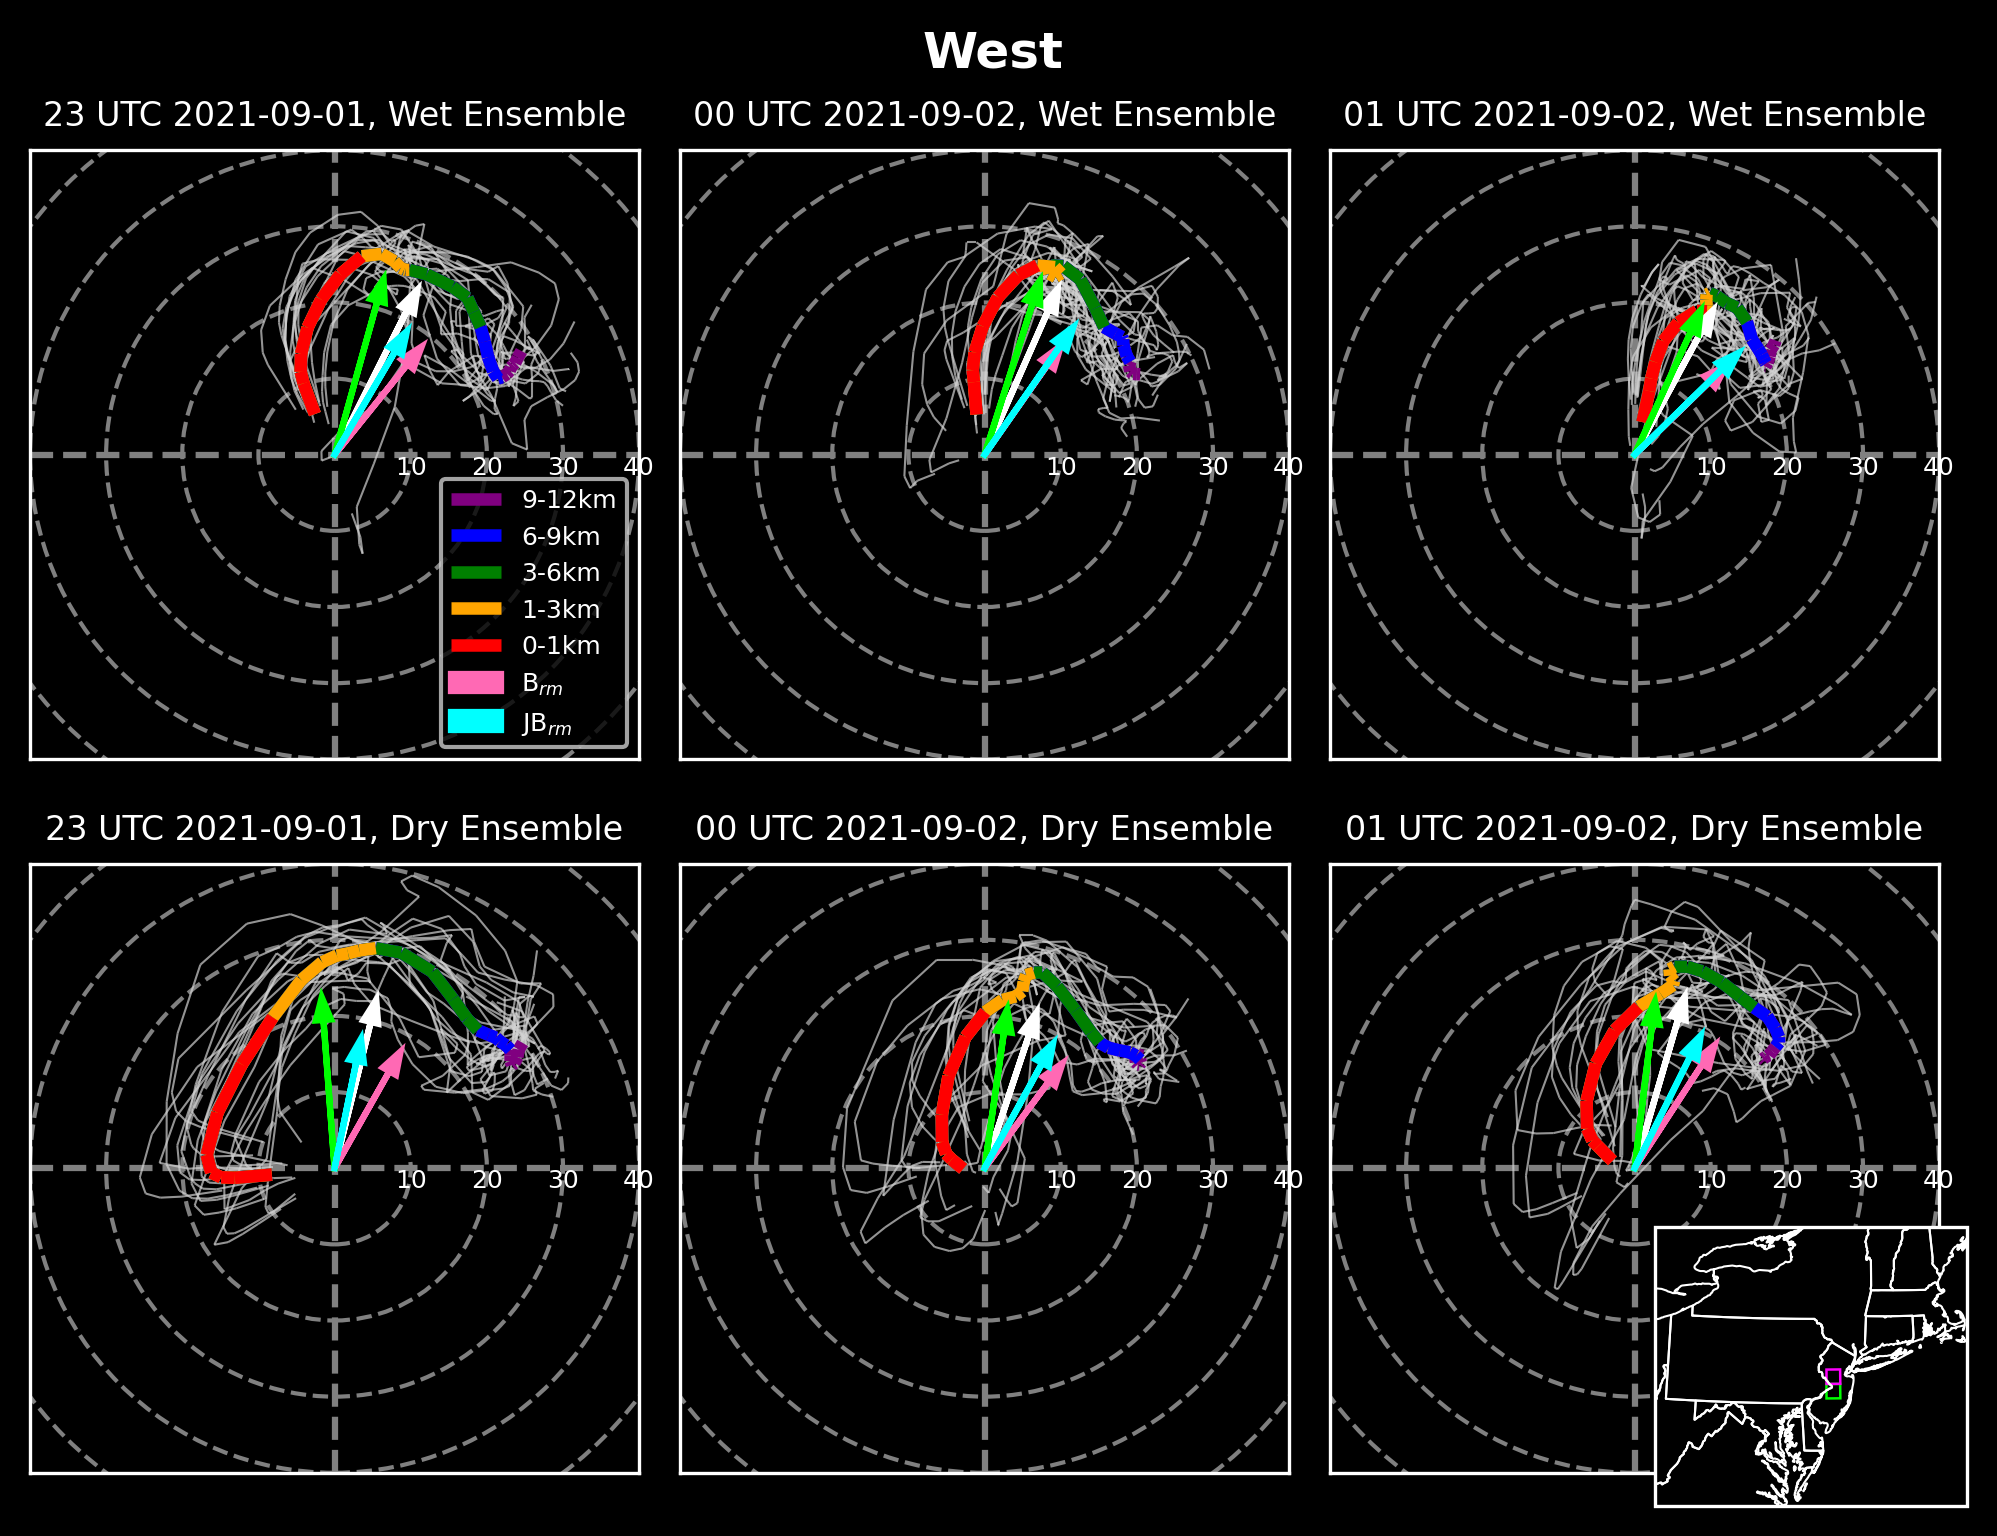

In [32]:
plot_hodographs_and_map(
    u_wet,
    v_wet,
    z_wet,
    u_dry,
    v_dry,
    z_dry,
    u_wet_mean,
    v_wet_mean,
    z_wet_mean,
    u_dry_mean,
    v_dry_mean,
    z_dry_mean,
    lat_coarse,
    lon_coarse,
    nx_ind-1-1,
    ny_ind,
    nx_ind-1,
    ny_ind,
    suptitle="West",
)


## 4x2 plots

In [11]:
def plot_hodographs_simple(
    u_wet,
    v_wet,
    z_wet,
    u_dry,
    v_dry,
    z_dry,
    u_wet_mean,
    v_wet_mean,
    z_wet_mean,
    u_dry_mean,
    v_dry_mean,
    z_dry_mean,
    lat_coarse,
    lon_coarse,
    nx_ind,
    ny_ind,
    suptitle="NNJ",
):
    # Create a 2x3 grid of subplots
    fig, axes = plt.subplots(2, 1, figsize=(2.5,5), dpi=300, layout="constrained")

    # Define times to plot (assuming time dimension exists)
    times_to_plot = u_wet_mean.coords["time"][-1:].values

    # Titles for each subplot using cftime strftime
    time_labels = [t.strftime("%H UTC %Y-%m-%d") for t in times_to_plot]
    titles = [f"{label}, Wet Ensemble" for label in time_labels] + [
        f"{label}, Dry Ensemble" for label in time_labels
    ]

    # Combine wet and dry data
    mean_us = [u_wet_mean, u_dry_mean]
    mean_vs = [v_wet_mean, v_dry_mean]
    mean_zs = [z_wet_mean, z_dry_mean]
    ensemble_us = [u_wet, u_dry]
    ensemble_vs = [v_wet, v_dry]
    ensemble_zs = [z_wet, z_dry]

    # Define height ranges in meters and corresponding colors
    height_ranges = [
        (9000, 12000, "purple", "9-12km"),
        (6000, 9000, "blue", "6-9km"),
        (3000, 6000, "green", "3-6km"),
        (1000, 3000, "orange", "1-3km"),
        (0, 1000, "red", "0-1km"),
    ]

    # Loop over wet/dry ensembles
    for i in range(2):  # 0: wet, 1: dry
        # Stack ensemble members
        us = (
            ensemble_us[i]
            .stack(dict(run=("init", "ne")))
            .transpose("run", "nz", "time")
        )
        vs = (
            ensemble_vs[i]
            .stack(dict(run=("init", "ne")))
            .transpose("run", "nz", "time")
        )
        zs = (
            ensemble_zs[i]
            .stack(dict(run=("init", "ne")))
            .transpose("run", "nz", "time")
        )

        mean_u = mean_us[i]
        mean_v = mean_vs[i]
        mean_z = mean_zs[i]

        # Loop over times
        for j, time_point in enumerate(times_to_plot):
            ax = axes[i]

            # Select data at the current time
            us_time = us.sel(time=time_point)
            vs_time = vs.sel(time=time_point)
            zs_time = zs.sel(time=time_point)

            mean_u_time = mean_u.sel(time=time_point)
            mean_v_time = mean_v.sel(time=time_point)
            mean_z_time = mean_z.sel(time=time_point)

            # Create hodograph
            hodograph = Hodograph(ax, component_range=40)
            hodograph.add_grid(increment=10)

            # Mask values above 12km for gray lines
            mask = mean_z_time.values < 12000
            for ens in range(us_time.shape[0]):
                hodograph.plot_colormapped(
                    us_time[ens, mask],
                    vs_time[ens, mask],
                    zs_time[ens, mask],
                    color="lightgray",
                    linewidth=0.5,
                    alpha=0.7,
                )

            # Plot the mean hodograph by height ranges
            for z_min, z_max, color, label in height_ranges:
                height_mask = mean_z_time.values < z_max
                hodograph.plot_colormapped(
                    mean_u_time[height_mask],
                    mean_v_time[height_mask],
                    mean_z_time[height_mask],
                    color=color,
                    label=label,
                )

            # Calculate and plot the layer mean wind (0-6km)
            layer_mean_u, layer_mean_v = calculate_layer_mean_wind(
                mean_u_time, mean_v_time, mean_z_time, z_min=0, z_max=6000
            )
            ax.arrow(
                0,
                0,
                layer_mean_u,
                layer_mean_v,
                color="white",
                head_width=2,
                head_length=3,
                linewidth=1.5,
                length_includes_head=True,
                zorder=5,
            )

            # Calculate shear
            shear = calculate_shear_vector(
                mean_u_time, mean_v_time, mean_z_time, z0=0, z1=6000
            )

            # Calculate Bunkers storm motion vector
            b_rm_u, b_rm_v = calculate_bunker_rm(
                np.array((layer_mean_u, layer_mean_v)), shear
            )
            print("Bunkers storm motion vector components: " + str(b_rm_u) +", " + str(b_rm_v))
            ax.arrow(
                0,
                0,
                b_rm_u,
                b_rm_v,
                color="hotpink",
                head_width=2,
                head_length=3,
                linewidth=1.5,
                length_includes_head=True,
                zorder=5,
                label=r"B$_{rm}$",
            )

            # Repeat but for 0-4km
            layer_mean_u, layer_mean_v = calculate_layer_mean_wind(
                mean_u_time, mean_v_time, mean_z_time, z_min=0, z_max=4000
            )
            ax.arrow(
                0,
                0,
                layer_mean_u,
                layer_mean_v,
                color="lime",
                head_width=2,
                head_length=3,
                linewidth=1.5,
                length_includes_head=True,
                zorder=5,
            )

                        # Calculate shear
            shear = calculate_shear_vector(
                mean_u_time, mean_v_time, mean_z_time, z0=0, z1=4000
            )

            # Calculate Bunkers storm motion vector
            b_rm_u, b_rm_v = calculate_bunker_rm(
                np.array((layer_mean_u, layer_mean_v)), shear
            )
            print("Janoski storm motion vector components: " + str(b_rm_u) +", " + str(b_rm_v))
            ax.arrow(
                0,
                0,
                b_rm_u,
                b_rm_v,
                color="cyan",
                head_width=2,
                head_length=3,
                linewidth=1.5,
                length_includes_head=True,
                zorder=5,
                label=r"JB$_{rm}$",
            )

            # Add circle labels at 10, 20, 30, 40, 50, 60
            circle_labels = np.arange(10, 50, 10)
            for label in circle_labels:
                ax.text(label, 0, str(label), fontsize=6, ha="center", va="top")

            # Remove the axis labels and ticks
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel("")
            ax.set_ylabel("")

            # Set the title for each subplot
            ax.set_title(titles[i + j], fontsize=8)

            # Add legend to the first subplot only
            if i == 0 and j == 0:
                ax.legend(fontsize=6, loc="lower right")

    # Add the map on the right side
    ax_map = fig.add_axes([0.6, -0.34, 0.35, 0.85], projection=proj)
    # Add state boundaries
    ax_map.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white", zorder=4)

    # Set the extent of the map to focus on the region of interest
    ax_map.set_extent(
        [lon_coarse.min(), lon_coarse.max(), lat_coarse.min(), lat_coarse.max()],
        crs=ccrs.PlateCarree(),
    )

    # Add red boxes over the grid boxes of interest for both wet and dry ensembles
    box_width = lon_coarse[0, 1] - lon_coarse[0, 0]  # Assuming evenly spaced grid
    box_height = lat_coarse[1, 0] - lat_coarse[0, 0]  # Assuming evenly spaced grid

    # Wet ensemble box
    rect_wet = Rectangle(
        (
            lon_coarse[nx_ind, ny_ind] - box_width / 2,
            lat_coarse[nx_ind, ny_ind] - box_height / 2,
        ),
        box_width,
        box_height,
        linewidth=0.6,
        edgecolor="lime",
        facecolor="none",
        transform=ccrs.PlateCarree(),
        zorder=3,
    )
    ax_map.add_patch(rect_wet)

    # Adjust the layout and add a super title
    plt.suptitle(suptitle, fontsize=12, fontweight="bold")
    plt.show()

In [12]:
# First, find the nx and ny closest to, say, Morristown
lat, lon = 40.7968, -74.4815

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat_coarse - lat) ** 2 + (lon_coarse - lon) ** 2)
mor_inds = distance.argmin(dim=["ny", "nx"])
ny_ind, nx_ind = int(mor_inds["nx"]), int(mor_inds["ny"])

u_wet = xr.concat(extract_data("u", wettest, ny_ind, nx_ind), dim=init)
v_wet = xr.concat(extract_data("v", wettest, ny_ind, nx_ind), dim=init)
z_wet = xr.concat(extract_data("z_agl", wettest, ny_ind, nx_ind), dim=init)

u_dry = xr.concat(extract_data("u", driest, ny_ind, nx_ind), dim=init)
v_dry = xr.concat(extract_data("v", driest, ny_ind, nx_ind), dim=init)
z_dry = xr.concat(extract_data("z_agl", driest, ny_ind, nx_ind), dim=init)

# Calculate ensemble means
u_wet_mean, u_dry_mean = u_wet.mean(dim=["ne", "init"]), u_dry.mean(dim=["ne", "init"])
v_wet_mean, v_dry_mean = v_wet.mean(dim=["ne", "init"]), v_dry.mean(dim=["ne", "init"])
z_wet_mean, z_dry_mean = z_wet.mean(dim=["ne", "init"]), z_dry.mean(dim=["ne", "init"])


Bunkers storm motion vector components: 13.856970395629258, 10.193926884762924
Janoski storm motion vector components: 11.386437174907638, 10.203249258374623
Bunkers storm motion vector components: 10.547356986974865, 16.211221778950417
Janoski storm motion vector components: 8.698675578618852, 17.46235718420469


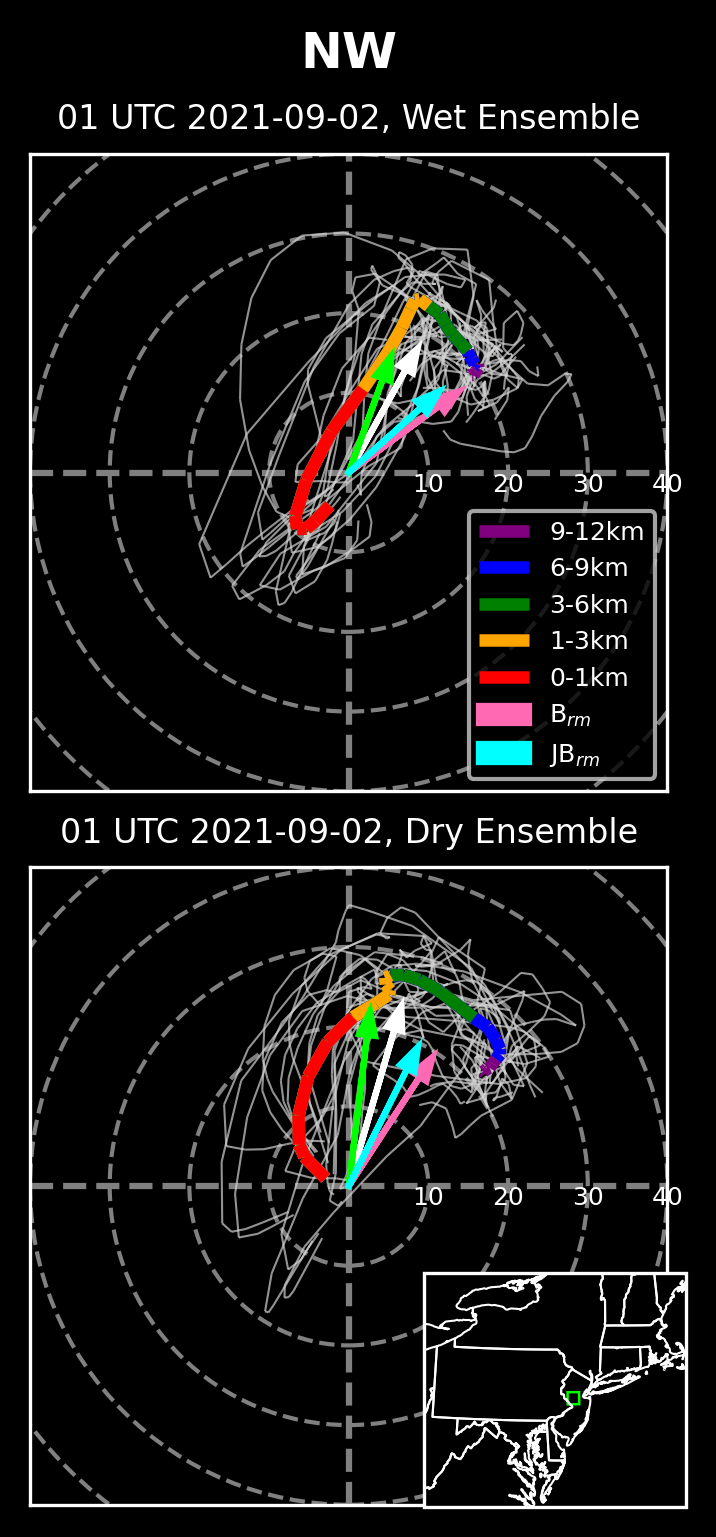

In [13]:
# First, find the nx and ny closest to, say, Morristown
lat, lon = 40.5, -74.4815

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat_coarse - lat) ** 2 + (lon_coarse - lon) ** 2)
mor_inds = distance.argmin(dim=["ny", "nx"])
ny_ind, nx_ind = int(mor_inds["nx"]), int(mor_inds["ny"])

u_wet = xr.concat(extract_data("u", wettest, ny_ind, nx_ind), dim=init)
v_wet = xr.concat(extract_data("v", wettest, ny_ind, nx_ind), dim=init)
z_wet = xr.concat(extract_data("z_agl", wettest, ny_ind, nx_ind), dim=init)

u_dry = xr.concat(extract_data("u", driest, ny_ind, nx_ind), dim=init)
v_dry = xr.concat(extract_data("v", driest, ny_ind, nx_ind), dim=init)
z_dry = xr.concat(extract_data("z_agl", driest, ny_ind, nx_ind), dim=init)

# Calculate ensemble means
u_wet_mean, u_dry_mean = u_wet.mean(dim=["ne", "init"]), u_dry.mean(dim=["ne", "init"])
v_wet_mean, v_dry_mean = v_wet.mean(dim=["ne", "init"]), v_dry.mean(dim=["ne", "init"])
z_wet_mean, z_dry_mean = z_wet.mean(dim=["ne", "init"]), z_dry.mean(dim=["ne", "init"])

plot_hodographs_simple(
    u_wet,
    v_wet,
    z_wet,
    u_dry,
    v_dry,
    z_dry,
    u_wet_mean,
    v_wet_mean,
    z_wet_mean,
    u_dry_mean,
    v_dry_mean,
    z_dry_mean,
    lat_coarse,
    lon_coarse,
    nx_ind,
    ny_ind,
    suptitle="NW"
)





Bunkers storm motion vector components: 13.136252088540722, 14.947906086079142
Janoski storm motion vector components: 12.736548061015696, 16.828526534220778
Bunkers storm motion vector components: 8.185668657080209, 15.79152075306687
Janoski storm motion vector components: 8.814263448669388, 17.811241333386874


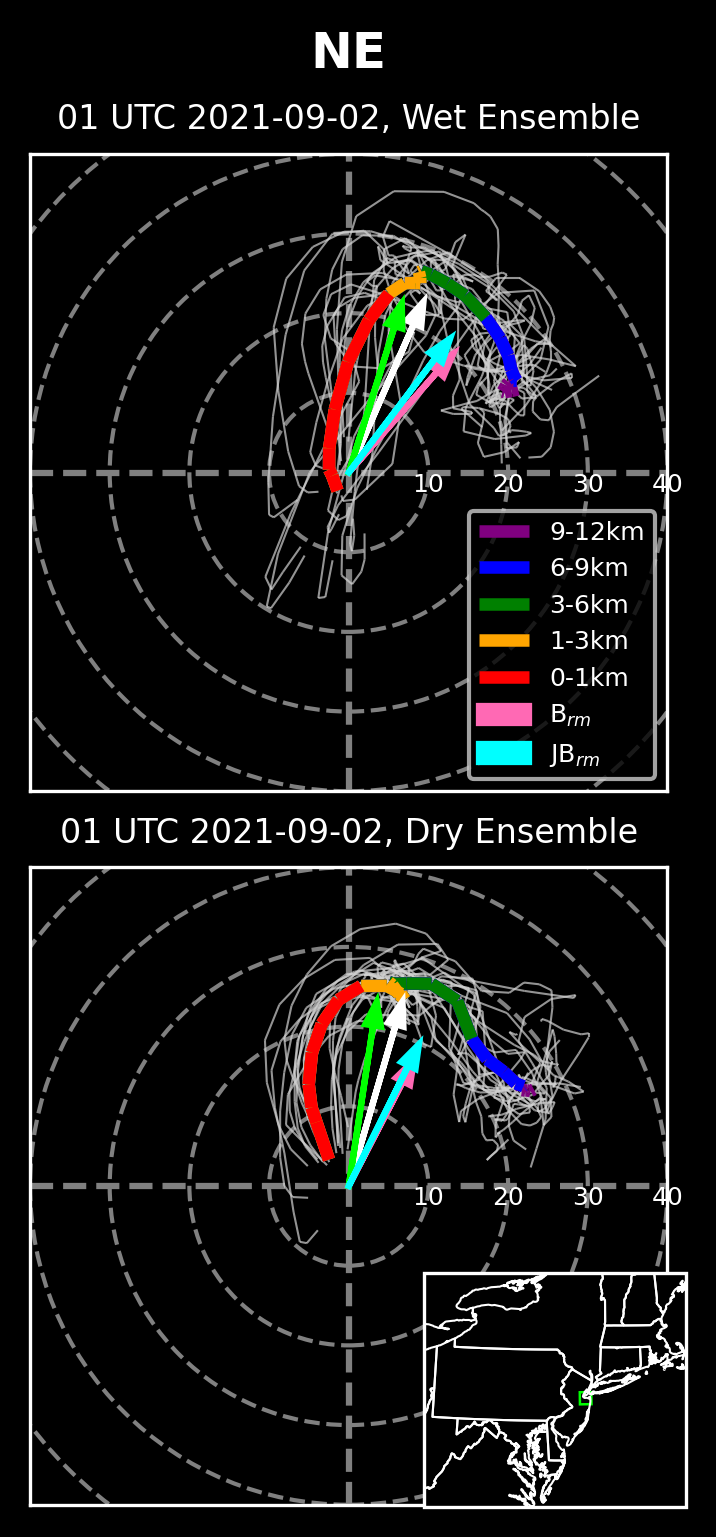

In [10]:
# First, find the nx and ny closest to, say, Morristown
lat, lon = 40.5, -74

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat_coarse - lat) ** 2 + (lon_coarse - lon) ** 2)
mor_inds = distance.argmin(dim=["ny", "nx"])
ny_ind, nx_ind = int(mor_inds["nx"]), int(mor_inds["ny"])

u_wet = xr.concat(extract_data("u", wettest, ny_ind, nx_ind), dim=init)
v_wet = xr.concat(extract_data("v", wettest, ny_ind, nx_ind), dim=init)
z_wet = xr.concat(extract_data("z_agl", wettest, ny_ind, nx_ind), dim=init)

u_dry = xr.concat(extract_data("u", driest, ny_ind, nx_ind), dim=init)
v_dry = xr.concat(extract_data("v", driest, ny_ind, nx_ind), dim=init)
z_dry = xr.concat(extract_data("z_agl", driest, ny_ind, nx_ind), dim=init)

# Calculate ensemble means
u_wet_mean, u_dry_mean = u_wet.mean(dim=["ne", "init"]), u_dry.mean(dim=["ne", "init"])
v_wet_mean, v_dry_mean = v_wet.mean(dim=["ne", "init"]), v_dry.mean(dim=["ne", "init"])
z_wet_mean, z_dry_mean = z_wet.mean(dim=["ne", "init"]), z_dry.mean(dim=["ne", "init"])

plot_hodographs_simple(
    u_wet,
    v_wet,
    z_wet,
    u_dry,
    v_dry,
    z_dry,
    u_wet_mean,
    v_wet_mean,
    z_wet_mean,
    u_dry_mean,
    v_dry_mean,
    z_dry_mean,
    lat_coarse,
    lon_coarse,
    nx_ind,
    ny_ind,
    suptitle="NE"
)



Bunkers storm motion vector components: 8.429320257125578, 15.954949103265957
Janoski storm motion vector components: 11.430742849485132, 18.15265761016034
Bunkers storm motion vector components: 7.720461536741826, 15.916618389783034
Janoski storm motion vector components: 9.876266365833084, 17.593418905377753


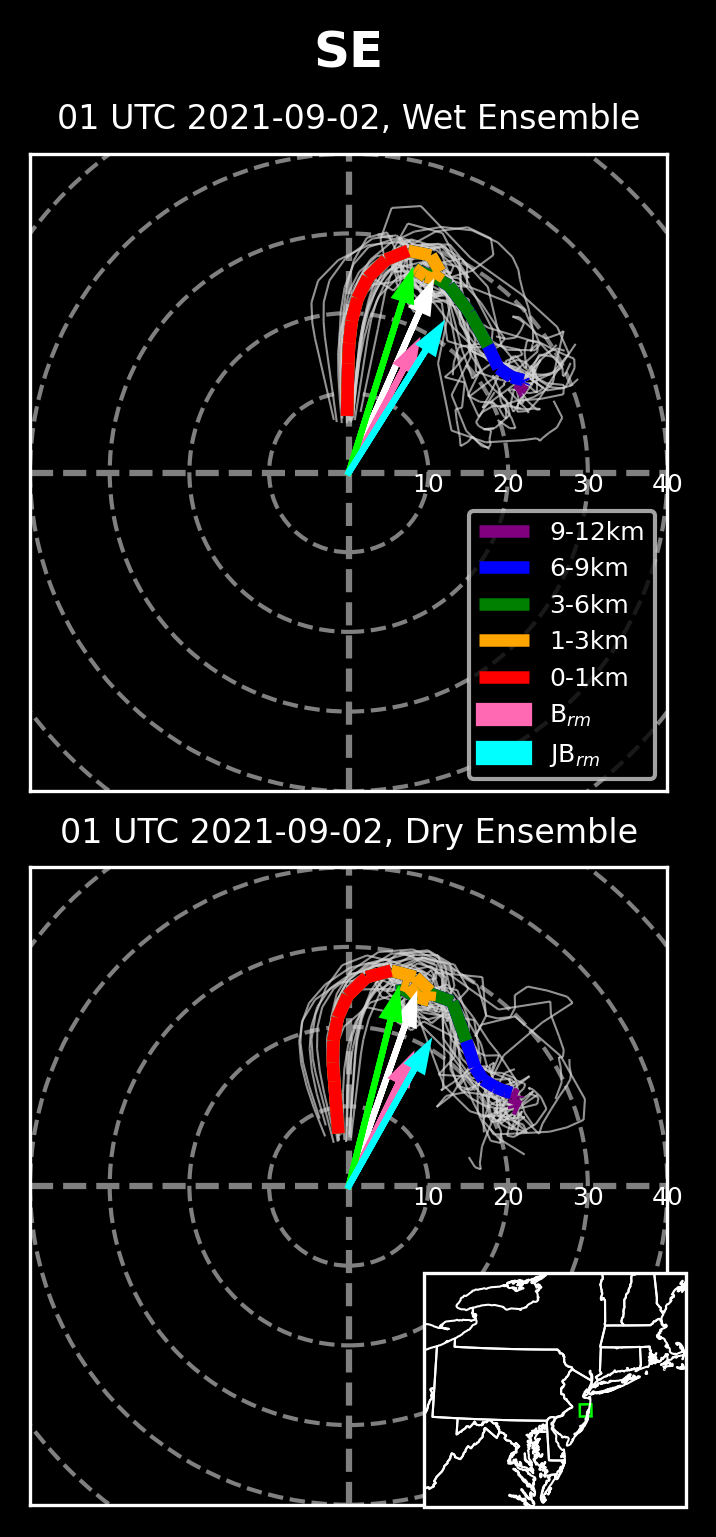

In [11]:
# First, find the nx and ny closest to, say, Morristown
lat, lon = 40.1, -74

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat_coarse - lat) ** 2 + (lon_coarse - lon) ** 2)
mor_inds = distance.argmin(dim=["ny", "nx"])
ny_ind, nx_ind = int(mor_inds["nx"]), int(mor_inds["ny"])

u_wet = xr.concat(extract_data("u", wettest, ny_ind, nx_ind), dim=init)
v_wet = xr.concat(extract_data("v", wettest, ny_ind, nx_ind), dim=init)
z_wet = xr.concat(extract_data("z_agl", wettest, ny_ind, nx_ind), dim=init)

u_dry = xr.concat(extract_data("u", driest, ny_ind, nx_ind), dim=init)
v_dry = xr.concat(extract_data("v", driest, ny_ind, nx_ind), dim=init)
z_dry = xr.concat(extract_data("z_agl", driest, ny_ind, nx_ind), dim=init)

# Calculate ensemble means
u_wet_mean, u_dry_mean = u_wet.mean(dim=["ne", "init"]), u_dry.mean(dim=["ne", "init"])
v_wet_mean, v_dry_mean = v_wet.mean(dim=["ne", "init"]), v_dry.mean(dim=["ne", "init"])
z_wet_mean, z_dry_mean = z_wet.mean(dim=["ne", "init"]), z_dry.mean(dim=["ne", "init"])

plot_hodographs_simple(
    u_wet,
    v_wet,
    z_wet,
    u_dry,
    v_dry,
    z_dry,
    u_wet_mean,
    v_wet_mean,
    z_wet_mean,
    u_dry_mean,
    v_dry_mean,
    z_dry_mean,
    lat_coarse,
    lon_coarse,
    nx_ind,
    ny_ind,
    suptitle="SE"
)



Bunkers storm motion vector components: 12.024022522206904, 11.6850942502316
Janoski storm motion vector components: 13.677758667041363, 13.403759439671584
Bunkers storm motion vector components: 9.685312766816933, 15.96577119474215
Janoski storm motion vector components: 10.647609087893034, 18.09983231786101


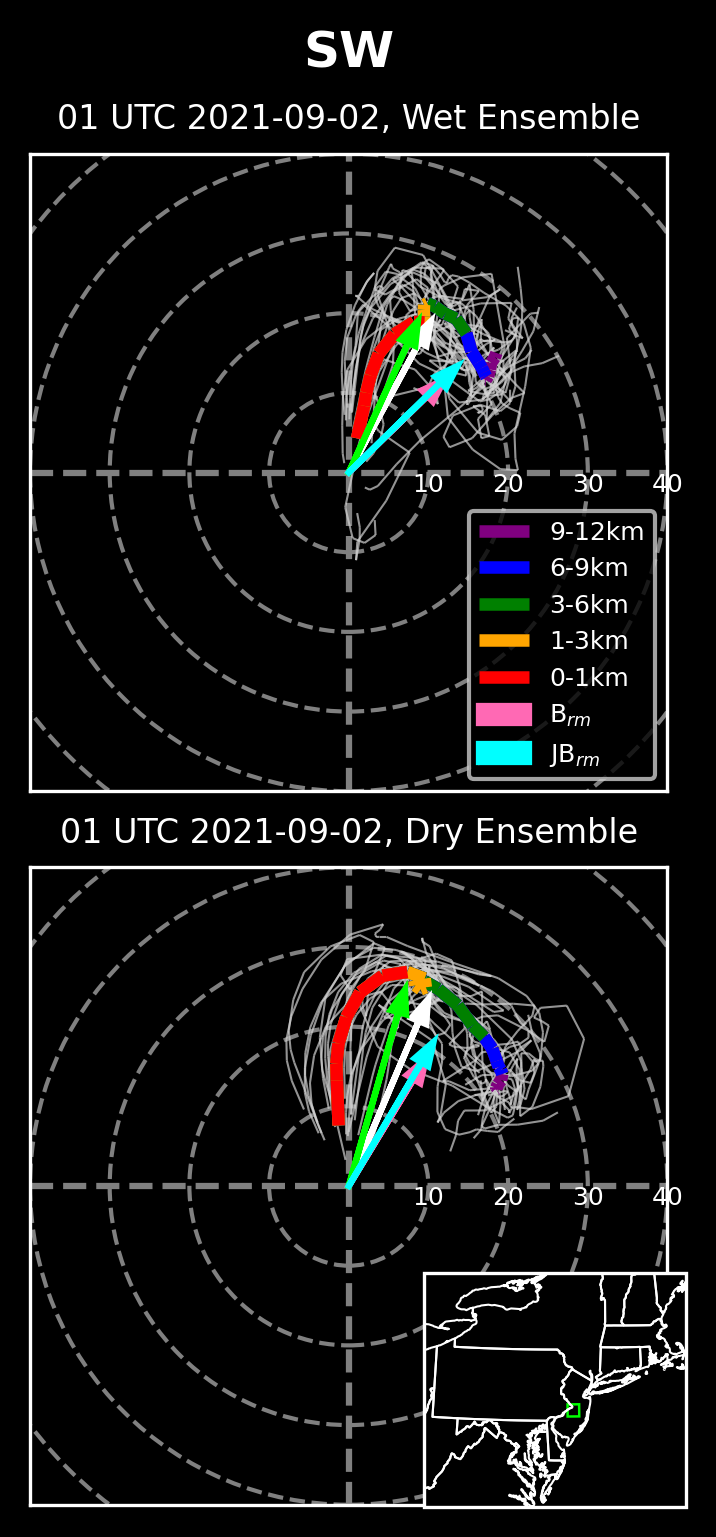

In [12]:
# First, find the nx and ny closest to, say, Morristown
lat, lon = 40.1, -74.5

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat_coarse - lat) ** 2 + (lon_coarse - lon) ** 2)
mor_inds = distance.argmin(dim=["ny", "nx"])
ny_ind, nx_ind = int(mor_inds["nx"]), int(mor_inds["ny"])

u_wet = xr.concat(extract_data("u", wettest, ny_ind, nx_ind), dim=init)
v_wet = xr.concat(extract_data("v", wettest, ny_ind, nx_ind), dim=init)
z_wet = xr.concat(extract_data("z_agl", wettest, ny_ind, nx_ind), dim=init)

u_dry = xr.concat(extract_data("u", driest, ny_ind, nx_ind), dim=init)
v_dry = xr.concat(extract_data("v", driest, ny_ind, nx_ind), dim=init)
z_dry = xr.concat(extract_data("z_agl", driest, ny_ind, nx_ind), dim=init)

# Calculate ensemble means
u_wet_mean, u_dry_mean = u_wet.mean(dim=["ne", "init"]), u_dry.mean(dim=["ne", "init"])
v_wet_mean, v_dry_mean = v_wet.mean(dim=["ne", "init"]), v_dry.mean(dim=["ne", "init"])
z_wet_mean, z_dry_mean = z_wet.mean(dim=["ne", "init"]), z_dry.mean(dim=["ne", "init"])

plot_hodographs_simple(
    u_wet,
    v_wet,
    z_wet,
    u_dry,
    v_dry,
    z_dry,
    u_wet_mean,
    v_wet_mean,
    z_wet_mean,
    u_dry_mean,
    v_dry_mean,
    z_dry_mean,
    lat_coarse,
    lon_coarse,
    nx_ind,
    ny_ind,
    suptitle="SW"
)



## Dry & Wet on Same Plot

In [8]:
def get_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Return a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [w[varname].sel(time=slice(start_time, end_time)) for w in wofs_list],
        dim=init_dim,
    ).chunk({"init": -1})

In [ ]:
# Get u and v
u_wet = get_field(wofs_wet, "u")

In [9]:
wofs_wet[0]

NameError: name 'wofs_wet' is not defined

In [ ]:
# First, find the nx and ny closest to, say, Morristown
lat, lon = 40.1, -74.5

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat_coarse - mor_lat) ** 2 + (lon_coarse - mor_lon) ** 2)
mor_inds = distance.argmin(dim=["ny", "nx"])
ny_ind, nx_ind = int(mor_inds["nx"]), int(mor_inds["ny"])

u_wet = xr.concat(extract_data("u", wettest, ny_ind, nx_ind), dim=init)
v_wet = xr.concat(extract_data("v", wettest, ny_ind, nx_ind), dim=init)
z_wet = xr.concat(extract_data("z_agl", wettest, ny_ind, nx_ind), dim=init)

u_dry = xr.concat(extract_data("u", driest, ny_ind, nx_ind-1), dim=init)
v_dry = xr.concat(extract_data("v", driest, ny_ind, nx_ind-1), dim=init)
z_dry = xr.concat(extract_data("z_agl", driest, ny_ind, nx_ind-1), dim=init)

# Calculate ensemble means
u_wet_mean, u_dry_mean = u_wet.mean(dim=["ne", "init"]), u_dry.mean(dim=["ne", "init"])
v_wet_mean, v_dry_mean = v_wet.mean(dim=["ne", "init"]), v_dry.mean(dim=["ne", "init"])
z_wet_mean, z_dry_mean = z_wet.mean(dim=["ne", "init"]), z_dry.mean(dim=["ne", "init"])


Signature:
extract_data(
    var: str,
    ne_index: Union[List[xarray.core.dataarray.DataArray], xarray.core.dataarray.DataArray],
    ny_ind: int,
    nx_ind: int,
) -> List[xarray.core.dataarray.DataArray]
Docstring: <no docstring>
File:      /tmp/ipykernel_324029/3704241753.py
Type:      function

In [ ]:
def plot_hodographs_simple(
    u_wet,
    v_wet,
    z_wet,
    u_dry,
    v_dry,
    z_dry,
    u_wet_mean,
    v_wet_mean,
    z_wet_mean,
    u_dry_mean,
    v_dry_mean,
    z_dry_mean,
    lat_coarse,
    lon_coarse,
    nx_ind,
    ny_ind,
    suptitle="NNJ",
):
    # Create a 2x3 grid of subplots
    fig, axes = plt.subplots(2, 1, figsize=(2.5,5), dpi=300, layout="constrained")

    # Define times to plot (assuming time dimension exists)
    times_to_plot = u_wet_mean.coords["time"][-1:].values

    # Titles for each subplot using cftime strftime
    time_labels = [t.strftime("%H UTC %Y-%m-%d") for t in times_to_plot]
    titles = [f"{label}, Wet Ensemble" for label in time_labels] + [
        f"{label}, Dry Ensemble" for label in time_labels
    ]

    # Combine wet and dry data
    mean_us = [u_wet_mean, u_dry_mean]
    mean_vs = [v_wet_mean, v_dry_mean]
    mean_zs = [z_wet_mean, z_dry_mean]
    ensemble_us = [u_wet, u_dry]
    ensemble_vs = [v_wet, v_dry]
    ensemble_zs = [z_wet, z_dry]

    # Define height ranges in meters and corresponding colors
    height_ranges = [
        (9000, 12000, "purple", "9-12km"),
        (6000, 9000, "blue", "6-9km"),
        (3000, 6000, "green", "3-6km"),
        (1000, 3000, "orange", "1-3km"),
        (0, 1000, "red", "0-1km"),
    ]

    # Loop over wet/dry ensembles
    for i in range(2):  # 0: wet, 1: dry
        # Stack ensemble members
        us = (
            ensemble_us[i]
            .stack(dict(run=("init", "ne")))
            .transpose("run", "nz", "time")
        )
        vs = (
            ensemble_vs[i]
            .stack(dict(run=("init", "ne")))
            .transpose("run", "nz", "time")
        )
        zs = (
            ensemble_zs[i]
            .stack(dict(run=("init", "ne")))
            .transpose("run", "nz", "time")
        )

        mean_u = mean_us[i]
        mean_v = mean_vs[i]
        mean_z = mean_zs[i]

        # Loop over times
        for j, time_point in enumerate(times_to_plot):
            ax = axes[i]

            # Select data at the current time
            us_time = us.sel(time=time_point)
            vs_time = vs.sel(time=time_point)
            zs_time = zs.sel(time=time_point)

            mean_u_time = mean_u.sel(time=time_point)
            mean_v_time = mean_v.sel(time=time_point)
            mean_z_time = mean_z.sel(time=time_point)

            # Create hodograph
            hodograph = Hodograph(ax, component_range=40)
            hodograph.add_grid(increment=10)

            # Mask values above 12km for gray lines
            mask = mean_z_time.values < 12000
            for ens in range(us_time.shape[0]):
                hodograph.plot_colormapped(
                    us_time[ens, mask],
                    vs_time[ens, mask],
                    zs_time[ens, mask],
                    color="lightgray",
                    linewidth=0.5,
                    alpha=0.7,
                )

            # Plot the mean hodograph by height ranges
            for z_min, z_max, color, label in height_ranges:
                height_mask = mean_z_time.values < z_max
                hodograph.plot_colormapped(
                    mean_u_time[height_mask],
                    mean_v_time[height_mask],
                    mean_z_time[height_mask],
                    color=color,
                    label=label,
                )

            # Calculate and plot the layer mean wind (0-6km)
            layer_mean_u, layer_mean_v = calculate_layer_mean_wind(
                mean_u_time, mean_v_time, mean_z_time, z_min=0, z_max=6000
            )
            ax.arrow(
                0,
                0,
                layer_mean_u,
                layer_mean_v,
                color="white",
                head_width=2,
                head_length=3,
                linewidth=1.5,
                length_includes_head=True,
                zorder=5,
            )

            # Calculate shear
            shear = calculate_shear_vector(
                mean_u_time, mean_v_time, mean_z_time, z0=0, z1=6000
            )

            # Calculate Bunkers storm motion vector
            b_rm_u, b_rm_v = calculate_bunker_rm(
                np.array((layer_mean_u, layer_mean_v)), shear
            )
            print("Bunkers storm motion vector components: " + str(b_rm_u) +", " + str(b_rm_v))
            ax.arrow(
                0,
                0,
                b_rm_u,
                b_rm_v,
                color="hotpink",
                head_width=2,
                head_length=3,
                linewidth=1.5,
                length_includes_head=True,
                zorder=5,
                label=r"B$_{rm}$",
            )

            # Repeat but for 0-4km
            layer_mean_u, layer_mean_v = calculate_layer_mean_wind(
                mean_u_time, mean_v_time, mean_z_time, z_min=0, z_max=4000
            )
            ax.arrow(
                0,
                0,
                layer_mean_u,
                layer_mean_v,
                color="lime",
                head_width=2,
                head_length=3,
                linewidth=1.5,
                length_includes_head=True,
                zorder=5,
            )

                        # Calculate shear
            shear = calculate_shear_vector(
                mean_u_time, mean_v_time, mean_z_time, z0=0, z1=4000
            )

            # Calculate Bunkers storm motion vector
            b_rm_u, b_rm_v = calculate_bunker_rm(
                np.array((layer_mean_u, layer_mean_v)), shear
            )
            print("Janoski storm motion vector components: " + str(b_rm_u) +", " + str(b_rm_v))
            ax.arrow(
                0,
                0,
                b_rm_u,
                b_rm_v,
                color="cyan",
                head_width=2,
                head_length=3,
                linewidth=1.5,
                length_includes_head=True,
                zorder=5,
                label=r"JB$_{rm}$",
            )

            # Add circle labels at 10, 20, 30, 40, 50, 60
            circle_labels = np.arange(10, 50, 10)
            for label in circle_labels:
                ax.text(label, 0, str(label), fontsize=6, ha="center", va="top")

            # Remove the axis labels and ticks
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel("")
            ax.set_ylabel("")

            # Set the title for each subplot
            ax.set_title(titles[i + j], fontsize=8)

            # Add legend to the first subplot only
            if i == 0 and j == 0:
                ax.legend(fontsize=6, loc="lower right")

    # Add the map on the right side
    ax_map = fig.add_axes([0.6, -0.34, 0.35, 0.85], projection=proj)
    # Add state boundaries
    ax_map.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white", zorder=4)

    # Set the extent of the map to focus on the region of interest
    ax_map.set_extent(
        [lon_coarse.min(), lon_coarse.max(), lat_coarse.min(), lat_coarse.max()],
        crs=ccrs.PlateCarree(),
    )

    # Add red boxes over the grid boxes of interest for both wet and dry ensembles
    box_width = lon_coarse[0, 1] - lon_coarse[0, 0]  # Assuming evenly spaced grid
    box_height = lat_coarse[1, 0] - lat_coarse[0, 0]  # Assuming evenly spaced grid

    # Wet ensemble box
    rect_wet = Rectangle(
        (
            lon_coarse[nx_ind, ny_ind] - box_width / 2,
            lat_coarse[nx_ind, ny_ind] - box_height / 2,
        ),
        box_width,
        box_height,
        linewidth=0.6,
        edgecolor="lime",
        facecolor="none",
        transform=ccrs.PlateCarree(),
        zorder=3,
    )
    ax_map.add_patch(rect_wet)

    # Adjust the layout and add a super title
    plt.suptitle(suptitle, fontsize=12, fontweight="bold")
    plt.show()